# Part 05 MACHINE LEARNING MODEL

# 0.0. Imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Save files
import pickle

# Warning
import warnings
warnings.filterwarnings( 'ignore' )

# Model selection
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Model's cross-validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, RandomizedSearchCV,\
GridSearchCV

# Model's metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, classification_report, auc

# Handling Oversampling
from imblearn.over_sampling import SMOTE 

## 0.1. Helper Functions

In [2]:
# Model's performance
def ml_scores(model_name, y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    return pd.DataFrame({'Accuracy': accuracy, 
                         'Precision': precision, 
                         'Recall': recall,
                         'F1': f1,
                         'ROC': roc}, 
                        index=[model_name])

In [3]:
# Confusion Matrix function
def conf_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    cm_data = pd.DataFrame(cm, columns = ['Positive', 'Negative'], index=['Positive', 'Negative'])
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 24}).set_title('Confusion Matrix')

    return plt.show()

In [16]:
# Model's performance function
def cross_val_performance(model, y_train, y_pred):
    # define scoring metrics
    scoring = {'Accuracy': 'accuracy',
               'Precision': make_scorer(precision_score),
               'Recall': make_scorer(recall_score),
               'F1': make_scorer(f1_score),
               'ROC': make_scorer(roc_auc_score)}

    # calculate scores with cross_validate
    scores = cross_validate(model, y_train, y_pred, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean().astype(str) + ' +/- ' + (performance.std()*2).astype(str)).T
    return performance

# 7.0. Machine Learning Modeling 

In [5]:
# Load dataset
feature_dtypes = {'step': 'float32',
                  'type': 'uint8',
                  'amount': 'float32',
                  'oldbalance_orig': 'float32',
                  'newbalance_orig': 'float32',
                  'oldbalance_dest': 'float32',
                  'newbalance_dest': 'float32',
                  'is_fraud': 'uint8',
                  'is_flagged_fraud': 'uint8',
                  'error_orig' : 'float32',
                  'error_dest' : 'float32',
                  'dest_type' : 'uint8',
                  'days' : 'float32'}


df3 = pd.read_csv('dataset\df3.csv', dtype=feature_dtypes)

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              float32
 1   type              uint8  
 2   amount            float32
 3   oldbalance_orig   float32
 4   newbalance_orig   float32
 5   oldbalance_dest   float32
 6   newbalance_dest   float32
 7   is_fraud          uint8  
 8   is_flagged_fraud  uint8  
 9   error_orig        float32
 10  error_dest        float32
 11  dest_type         uint8  
 12  days              float32
dtypes: float32(9), uint8(4)
memory usage: 242.7 MB


In [7]:
# Boruta feature
boruta_select = ['step',
 'type',
 'amount',
 'oldbalance_orig',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'is_flagged_fraud',
 'error_orig',
 'error_dest',
 'dest_type',
 'days']

## 7.1. Spliting Into Train, Valid and Test

In [8]:
df4 = df3.copy()

# Remove target variable from train set
X = df4[boruta_select]
Y = df4.is_fraud

# Spliting
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 47)

In [9]:
# Since Data Set is imbalanced, SMOTE will apply_train to balance representatoin of Response feature
print("Shape of x_train before over-Sampling:", x_train.shape)
print("Shape of y_train before over-Sampling:", y_train.shape)
print("---" * 15)
print('Proportion of target variable before over-Sampling:')
print(y_train.value_counts())

# SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

print("Shape of x_train after over-Sampling:", x_train.shape)
print("Shape of y_train after over-Sampling:", y_train.shape)
print("---" * 15)
print('Proportion of target variable after over-Sampling:')
print(y_train.value_counts())

Shape of x_train before over-Sampling: (5090096, 12)
Shape of y_train before over-Sampling: (5090096,)
---------------------------------------------
Proportion of target variable before over-Sampling:
0    5083488
1       6608
Name: is_fraud, dtype: int64
Shape of x_train after over-Sampling: (10166976, 12)
Shape of y_train after over-Sampling: (10166976,)
---------------------------------------------
Proportion of target variable after over-Sampling:
1    5083488
0    5083488
Name: is_fraud, dtype: int64


## 7.2. Baseline: Dummy Classifier

In [10]:
# Model and fit
dummy = DummyClassifier().fit(x_train, y_train)

# Predicting
y_pred = dummy.predict(x_test)

### 7.2.1. Baseline performance

In [11]:
Dummy_performance = ml_scores('Baseline', y_test, y_pred)
Dummy_performance

,Accuracy,Precision,Recall,F1,ROC
Baseline,0.499483,0.00125,0.49595,0.002493,0.497719


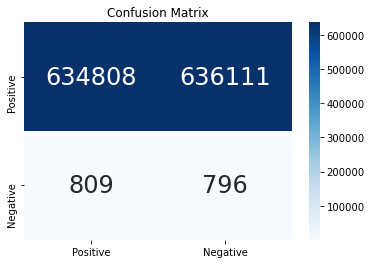

In [12]:
conf_matrix(y_test, y_pred)

## 7.3. Logistic Regression

### 7.3.1. Logistic Regression model fit

In [13]:
# Model and fit
lr = LogisticRegression().fit(x_train, y_train)

# Predicting
y_pred_lr = lr.predict(x_test)

### 7.3.2. Logistic Regression performance

In [14]:
performance_lr = ml_scores('Logistic Regression', y_test, y_pred_lr)
performance_lr

,Accuracy,Precision,Recall,F1,ROC
Logistic Regression,0.960864,0.02749,0.87352,0.053303,0.917247


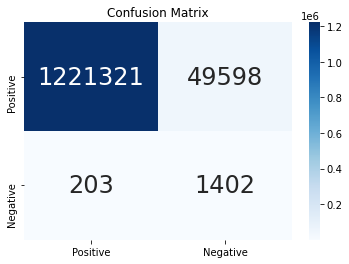

In [15]:
conf_matrix(y_test, y_pred_lr)

## 7.4. Random Forest Classifier

### 7.4.1. Random Forest Classifier model and fit

In [18]:
# Model and fit
rfc = RandomForestClassifier().fit(x_train, y_train)

# Predicting
y_pred_rfc = rfc.predict(x_test)

### 7.4.2. Random Forest Classifier performance

In [19]:
rfc_performance = ml_scores('Random Forest', y_test, y_pred_rfc)
rfc_performance

,Accuracy,Precision,Recall,F1,ROC
Random Forest,0.999992,0.997505,0.996262,0.996883,0.998129


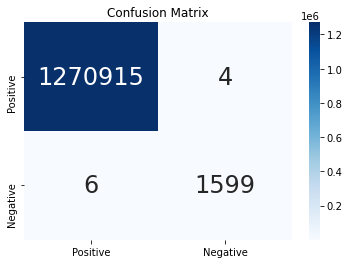

In [20]:
conf_matrix(y_test, y_pred_rfc)

## 7.5. XGBoost Classifier

### 7.5.1. XGBoost Classifier model and fit

In [21]:
xgb = XGBClassifier().fit(x_train, y_train)

# Predicting
y_pred_xgb = xgb.predict(x_test)

[13:13:21] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


### 7.5.2. XGBoost Classifier performance

In [22]:
xgb_performance = ml_scores('XGBoost Classifier', y_test, y_pred_xgb)
xgb_performance

,Accuracy,Precision,Recall,F1,ROC
XGBoost Classifier,0.999939,0.95746,0.995639,0.976176,0.997791


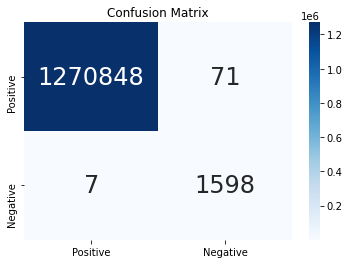

In [23]:
conf_matrix(y_test, y_pred_xgb)

## 7.6. Results

In [24]:
performance = pd.concat([Dummy_performance, performance_lr, rfc_performance, xgb_performance])
performance

,Accuracy,Precision,Recall,F1,ROC
Baseline,0.499483,0.001250,0.495950,0.002493,0.497719
Logistic Regression,0.960864,0.027490,0.873520,0.053303,0.917247
Random Forest,0.999994,0.998751,0.996262,0.997505,0.998130
XGBoost Classifier,0.999939,0.957460,0.995639,0.976176,0.997791


# 8.0. Cross Validation

## 8.1. Logistic Regression

In [28]:
lr_cv = cross_val_performance(lr, x_train, y_train)
lr_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9164 +/- 0.0045,0.9447 +/- 0.0277,0.8851 +/- 0.038,0.9136 +/- 0.0076,0.9164 +/- 0.0045


## 8.2. Random Forest Classifier

In [21]:
rfc_cv = cross_val_performance(rfc, x_train, y_train)
rfc_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9999903609499077 +/- 1.4802377865535678e-05,0.9999954755527607 +/- 1.1440221213433658e-05,0.9999852463528592 +/- 3.104806475030822e-05,0.9999903608527762 +/- 1.4802823138185764e-05,0.9999903609504882 +/- 1.4802376916999629e-05


## 8.3. XGBoost Classifier

In [30]:
xgb_cv = cross_val_performance(xgb, x_train, y_train)
xgb_cv

[21:52:30] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[22:17:44] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[22:43:27] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[23:10:07] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[23:41:02] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_meth

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9985 +/- 0.0002,0.9999 +/- 0.0,0.9971 +/- 0.0003,0.9985 +/- 0.0002,0.9985 +/- 0.0002


## 8.4. Results

In [31]:
index = ['Logistic Regression', 'Random Forest Classifier', 'XGBoost Classifier']

performance_cv = pd.concat([lr_cv, rfc_cv, xgb_cv])
performance_cv.index = index
performance_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
Logistic Regression,0.9164 +/- 0.0045,0.9447 +/- 0.0277,0.8851 +/- 0.038,0.9136 +/- 0.0076,0.9164 +/- 0.0045
Random Forest Classifier,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0
XGBoost Classifier,0.9985 +/- 0.0002,0.9999 +/- 0.0,0.9971 +/- 0.0003,0.9985 +/- 0.0002,0.9985 +/- 0.0002


In [34]:
# Saving Best models

# Random Forest
pickle.dump(rfc, open('models/rfc.pkl', 'wb'))


# XGBoost
pickle.dump(xgb, open('models/xgb.pkl', 'wb'))

# 9.0. Hyperparameter Fine Tuning

In [19]:
# Load Machine Learning Models
rfc = pickle.load(open('models/rfc.pkl', 'rb'))

## 9.1. GridSearchCV

In [20]:
# Parameters
parameters = { 
    'n_estimators': np.arange(10, 105, 30),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(2, 12, 4),
    'criterion' :['gini', 'entropy']
}

rfc_tunned = GridSearchCV(
    estimator=rfc,
    param_grid=nuparameters,
    scoring = 'f1',
    verbose=2,
    n_jobs = -1 )
rfc_tunned.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 476.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 1319.2min finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 2,  6, 10]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 10,  40,  70, 100])},
             scoring='f1', verbose=2)

In [21]:
rfc_tunned.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 10}

In [ ]:
best_param = {'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 10}

# 10.0. Final Model

## 10.1. Random Forest Classifier +

In [12]:
# Model and fit
rfc_tunned = RandomForestClassifier(
    criterion = 'entropy',
    max_depth = 10,
    max_features = 'sqrt',
    n_estimators = 10
).fit(x_train, y_train)

# Predict
y_pred_rfc_t = rfc_tunned.predict(x_test)

### 10.1.1. Random Forest Classifier + Performance

In [14]:
# Performance
rfc_tunned_performance = ml_scores('Random Forest', y_test, y_pred_rfc_t)
rfc_tunned_performance

,Accuracy,Precision,Recall,F1,ROC
Random Forest,0.999991,0.996883,0.996262,0.996572,0.998129


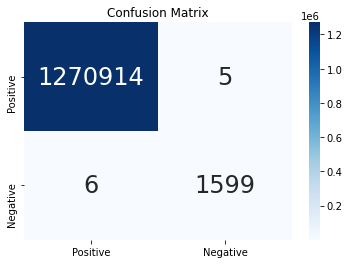

In [15]:
# Cofusion matrix
conf_matrix(y_test, y_pred_rfc_t)


### 10.1.2. Cross validation tunned version

In [17]:
# Cross validation
rfc_tunned_cv = cross_val_performance(rfc_tunned, x_train, y_train)
rfc_tunned_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9986719747882166 +/- 0.000349312854856119,0.9999934920379937 +/- 9.30282963761035e-06,0.9973504412260782 +/- 0.0007037845131346804,0.9986701894925369 +/- 0.00035021496632904007,0.9986719748110474 +/- 0.00034931241906775045


In [26]:
pickle.dump(rfc_tunned, open('models/rfc_tunned.pkl', 'wb'))